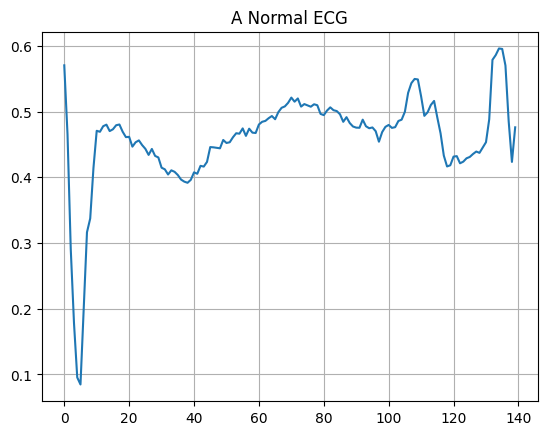

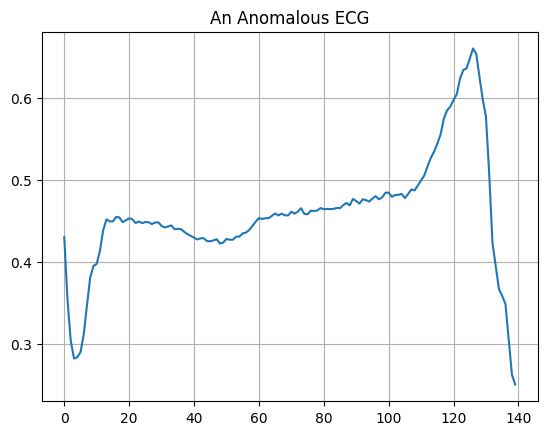

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

# A normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

# An abnormal ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()


In [2]:
raw_data.shape

(4998, 141)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 834.3275 - val_loss: 243.6741
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 227.1531 - val_loss: 180.0398
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165.9868 - val_loss: 134.9576
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 127.5467 - val_loss: 108.2301
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.2781 - val_loss: 90.4504
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.1923 - val_loss: 75.9461
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.0742 - val_loss: 65.4343
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.2378 - val_loss: 56.8589
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.0937 - val_loss: 50.0110
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.6101 - val_loss: 44.3078
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.0581 - val_loss: 39.4488
Epoch 12/100
74/74 ━━━━━━━━━━━━━

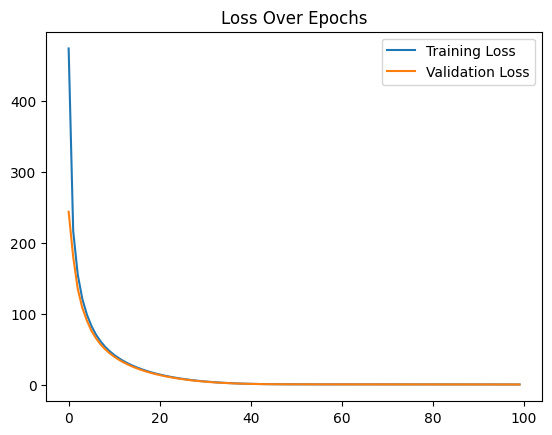

In [3]:
import tensorflow as tf
import numpy as np

# Ensure train_data is not None
if train_data is None:
    raise ValueError("train_data is None. Please ensure it is properly initialized.")

# Define the autoencoder model
input_dim = train_data.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoder_layer1 = Dense(256, activation='sigmoid', name='encoder_layer1')(input_layer)
encoder_layer2 = Dense(128, activation='sigmoid', name='encoder_layer2')(encoder_layer1)
encoder_layer3 = Dense(64, activation='sigmoid', name='encoder_layer3')(encoder_layer2)
bottleneck = Dense(32, activation='sigmoid', name='bottleneck')(encoder_layer3)

# Decoder: Three layers mirroring the encoder
decoder_layer1 = Dense(64, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoder_layer2 = Dense(128, activation='sigmoid', name='decoder_layer2')(decoder_layer1)
decoder_layer3 = Dense(256, activation='sigmoid', name='decoder_layer3')(decoder_layer2)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoder_layer3)

autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-3, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data, 
    y=normal_train_data,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=32, 
    validation_data=(normal_test_data, normal_test_data)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [4]:
'''def get_layer_activations(model, data):
        layer_outputs = [layer.output for layer in model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

activations = get_layer_activations(autoencoder, normal_train_data)
for activation in activations:
    print(f"Shape of activation: {activation.shape}")

kl_divergence = 0
for i, activation in enumerate(activations):
        rho_hat_layer = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
        #if i == 4:        
        tf.print(rho_hat_layer)
        #tf.print(activation)
        for rho_hat in rho_hat_layer:
                #tf.print(rho_hat)
                kl_divergence += tf.reduce_sum(
                0.01 * tf.math.log(0.01 / (rho_hat_layer + 1e-7)) +
                (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat_layer + 1e-7))
                )
                tf.print(kl_divergence)'''

'def get_layer_activations(model, data):\n        layer_outputs = [layer.output for layer in model.layers if \'encoder\' in layer.name or \'decoder\' in layer.name or \'bottleneck\' in layer.name]\n        activation_model = Model(inputs=model.input, outputs=layer_outputs)\n        activations = activation_model(data)\n        return activations\n\nactivations = get_layer_activations(autoencoder, normal_train_data)\nfor activation in activations:\n    print(f"Shape of activation: {activation.shape}")\n\nkl_divergence = 0\nfor i, activation in enumerate(activations):\n        rho_hat_layer = tf.reduce_mean(activation, axis=0)  # Average activation per neuron\n        #if i == 4:        \n        tf.print(rho_hat_layer)\n        #tf.print(activation)\n        for rho_hat in rho_hat_layer:\n                #tf.print(rho_hat)\n                kl_divergence += tf.reduce_sum(\n                0.01 * tf.math.log(0.01 / (rho_hat_layer + 1e-7)) +\n                (1 - 0.01) * tf.math.log((1 - 0

#### Reconstrução

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


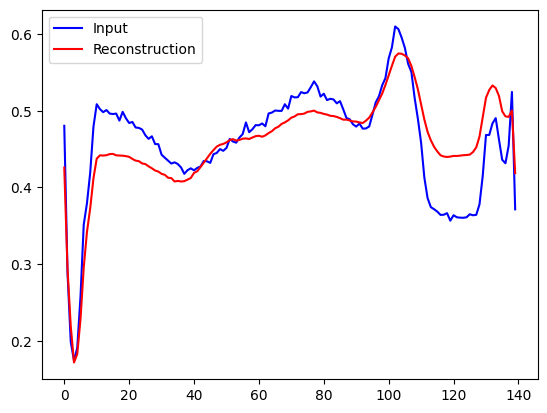

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


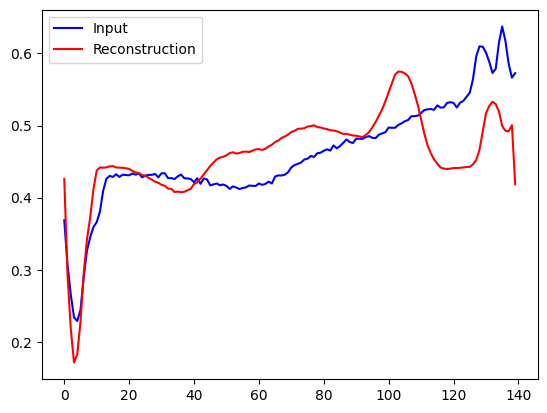

In [5]:
# Evaluate model performance on test data
decoded_data = autoencoder.predict(normal_test_data)

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
#plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

decoded_data = autoencoder.predict(anomalous_test_data)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
#plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

#### Avaliação

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
Threshold:  0.032770418
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


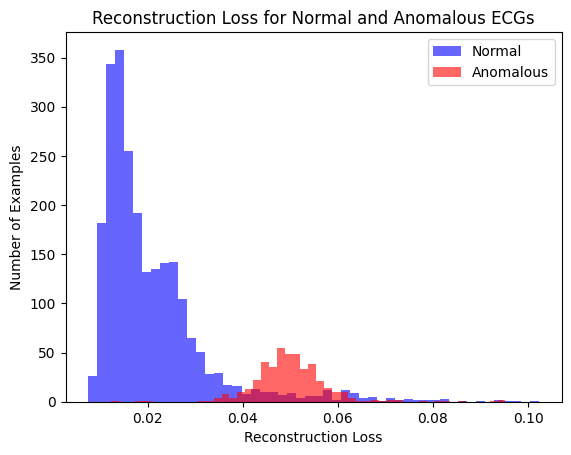

Accuracy = 94.6%
Precision = 99.22178988326849%
Recall = 91.07142857142857%


In [7]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_normal, normal_train_data)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions_anomalous = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=50, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous ECGs")
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(labels, predictions)))
    print("Precision = {}%".format(100*precision_score(labels, predictions)))
    print("Recall = {}%".format(100*recall_score(labels, predictions)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)